># Inception V3

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/26/class-26-226.jpg  
  inflating: data/26/class-26-227.jpg  
  inflating: data/26/class-26-228.jpg  
  inflating: data/26/class-26-229.jpg  
  inflating: data/26/class-26-23.jpg  
  inflating: data/26/class-26-230.jpg  
  inflating: data/26/class-26-231.jpg  
  inflating: data/26/class-26-232.jpg  
  inflating: data/26/class-26-233.jpg  
  inflating: data/26/class-26-234.jpg  
  inflating: data/26/class-26-235.jpg  
  inflating: data/26/class-26-236.jpg  
  inflating: data/26/class-26-237.jpg  
  inflating: data/26/class-26-238.jpg  
  inflating: data/26/class-26-239.jpg  
  inflating: data/26/class-26-24.jpg  
  inflating: data/26/class-26-240.jpg  
  inflating: data/26/class-26-241.jpg  
  inflating: data/26/class-26-242.jpg  
  inflating: data/26/class-26-243.jpg  
  inflating: data/26/class-26-244.jpg  
  inflating: data/26/class-26-245.jpg  
  inflating: data/26/class-26-246.jpg  
  inflating: data/26/class-26-2

In [4]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

Found 8320 images belonging to 38 classes.
Found 2059 images belonging to 38 classes.
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/50
260/260 [==============================] - 155s 551ms/step - loss: 3.5643 - accuracy: 0.0629 - val_loss: 3.4048 - val_accuracy: 0.1219 - lr: 1.0000e-04
Epoch 2/50
260/260 [==============================] - 143s 547ms/step - loss: 3.2356 - accuracy: 0.1371 - val_loss: 3.0726 - val_accuracy: 0.1914 - lr: 1.0000e-04
Epoch 3/50
260/260 [==============================] - 141s 541ms/step - loss: 2.9213 - accuracy: 0.1935 - val_loss: 2.8440 - val_accuracy: 0.2098 - lr: 1.0000e-04
Epoch 4/50
260/260 [==============================] - 156s 599ms/step - loss: 2.6703 - accuracy: 0.2495 - val_loss: 2.6739 - val_accuracy: 0.2365 - lr: 1.0000e-04
Epoch 5/50
260/260 [==============================] - 155s 597ms/step - loss: 2.5085 - accuracy: 0.2755 - val_loss: 2.5858 - val_accuracy: 0.2584 - lr: 1.0000e-04
Epoch 6/50
260/260 [==============

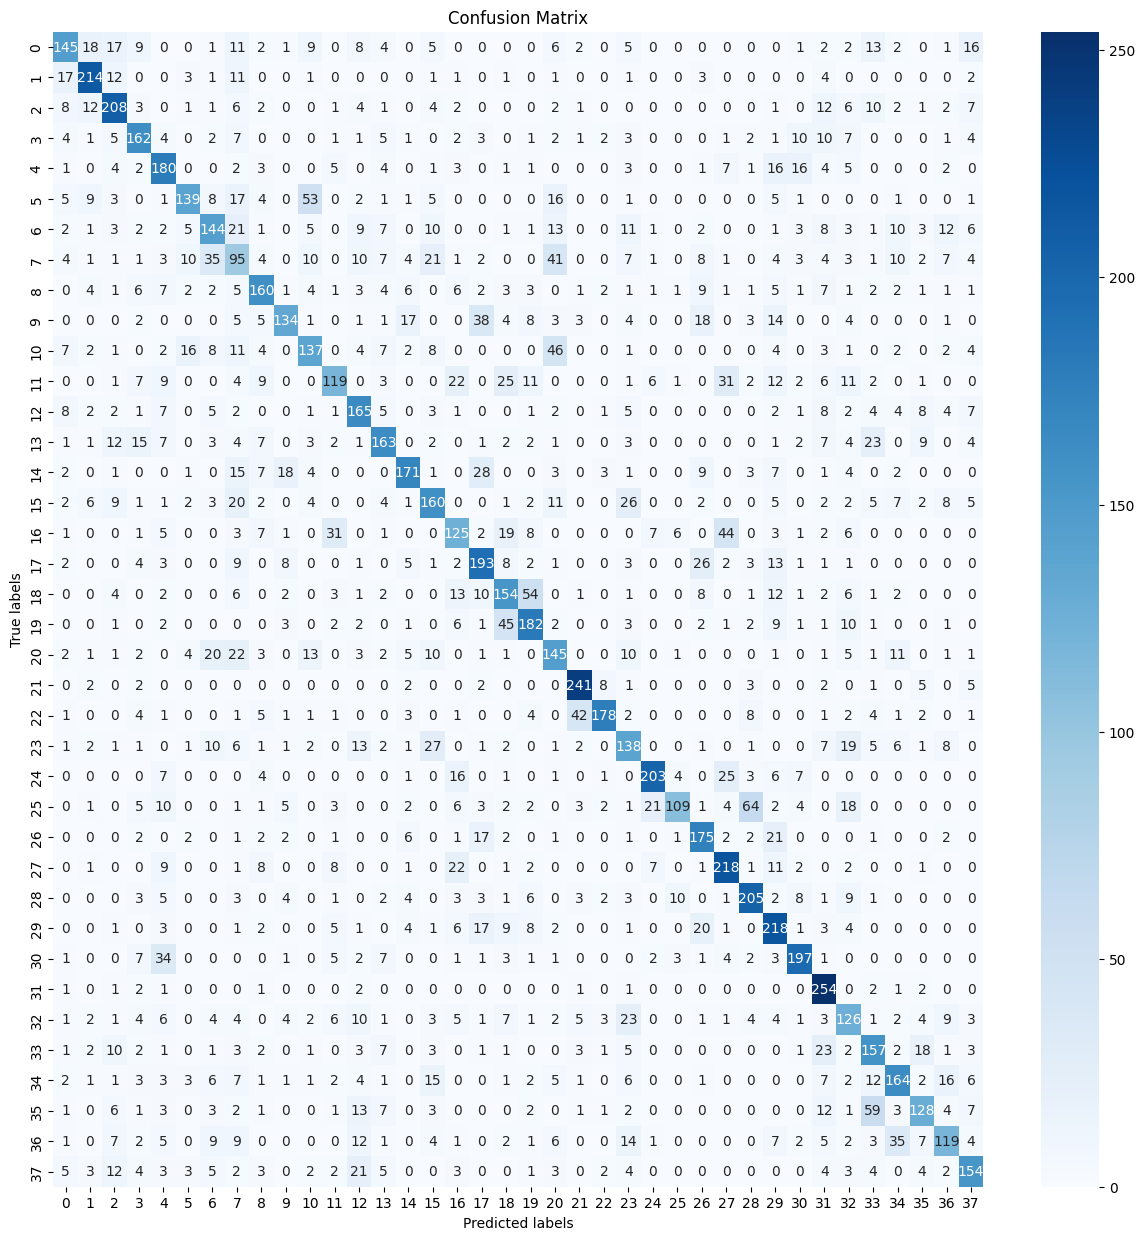

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.52      0.57       280
           1       0.75      0.78      0.77       273
           2       0.64      0.70      0.67       297
           3       0.62      0.67      0.64       243
           4       0.55      0.69      0.61       262
           5       0.72      0.51      0.60       273
           6       0.53      0.50      0.52       288
           7       0.30      0.31      0.31       305
           8       0.64      0.62      0.63       258
           9       0.72      0.50      0.59       266
          10       0.54      0.50      0.52       272
          11       0.59      0.42      0.49       285
          12       0.56      0.65      0.60       252
          13       0.64      0.58      0.61       280
          14       0.72      0.61      0.66       281
          15       0.56      0.55      0.55       293
          16       0.50      0.46      0.48       273
    

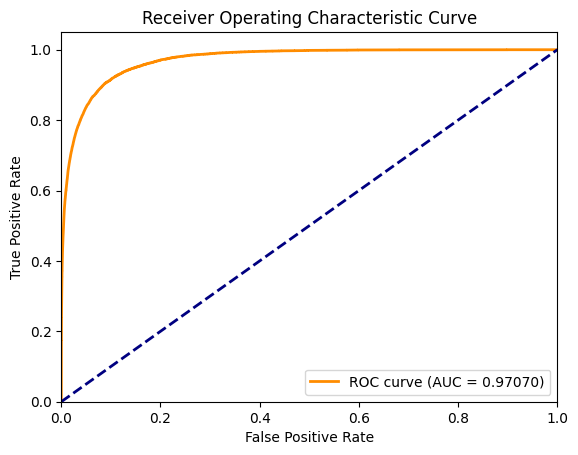

In [5]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define directories and parameters
folder_dir = '/content/data'
SIZE = 224
no_of_classes = 38
batch_size = 32
picture_size = (SIZE, SIZE)
epochs = 50

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255  # Rescale pixel values
)

train_set = train_datagen.flow_from_directory(
    directory=folder_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=22
)

validation_set = train_datagen.flow_from_directory(
    directory=folder_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=22
)

# Model building
base_model = Xception(weights="imagenet", input_shape=(SIZE, SIZE, 3), include_top=False)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(no_of_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    metrics=['accuracy']
)

# Fine-tuning by unfreezing some layers
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
callbacks = [lr_scheduler, early_stopping]

history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=validation_set,
    callbacks=callbacks
)

# Evaluate on test set
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values
test_generator = test_datagen.flow_from_directory(
    directory='/content/data',  # Update to your test data directory
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)

# Compute and display metrics
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred))

roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
